In [12]:
from typing import List

import pytorch_lightning as pl
import torch
import wandb
import uuid
from torch import nn

from datamodule import SpritesDataModule
from simple_vae import ConvVAE
from beta_vae import ConvBetaVAE

import matplotlib.pyplot as plt
import numpy as np
import os
from rich.progress import track
from torchmetrics.image import FrechetInceptionDistance

In [13]:
SEED = 42

# Assignment 2

## Training the Model

**Run following script**
`python simple_vae.py`

Training Code in script:
```python
dm = SpritesDataModule(
    dir="dsprites-dataset",
    batch_size=512,
    val_split=0.9,
    transforms=None,
    seed=SEED,
)
dm.setup()
model = ConvVAE(
    in_channels=1,
    latent_dim=6,
    encoder_decoder_dims=[64, 128, 256, 512, 1024],
)
# Wandb logger
wandb_logger = pl.loggers.WandbLogger(project="VAE", name=f"ConvVAE_{uuid.uuid4()}")
es = pl.callbacks.EarlyStopping(monitor="val_loss", patience=5)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename=f"ConvVAE_{uuid.uuid4()}" + "-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)
trainer = pl.Trainer(
    accelerator="gpu",
    callbacks=[es, checkpoint_callback],
    max_epochs=50,
    logger=wandb_logger,
    fast_dev_run=False,
)
trainer.fit(model, dm)
```

## Loading the Dataloaders

In [3]:
dm = SpritesDataModule(
        dir="dsprites-dataset",
        batch_size=128,
        val_split=0.9,
        transforms=None,
        seed=SEED,
    )

dm.setup("fit")

## Loading the Trained Model

In [12]:
model_checkpoint = 'ConvVAE_86d92a1d-af98-4869-beee-5767afa6c92d-epoch=46-val_loss=11750.68.ckpt'

In [14]:
model = ConvVAE.load_from_checkpoint(f"checkpoints/{model_checkpoint}")
model.eval()

## Generate Samples and Plot them

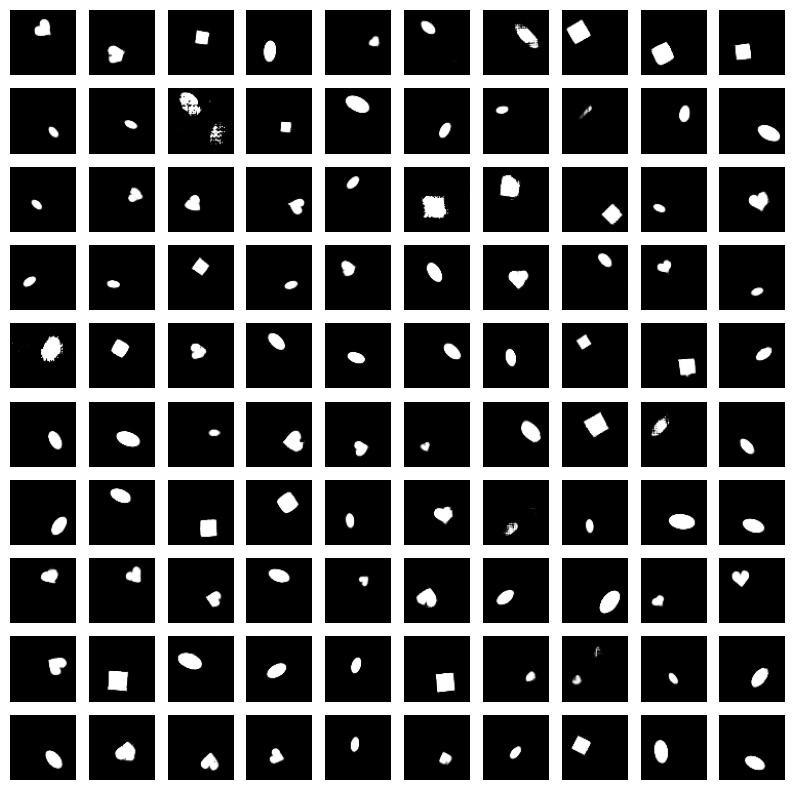

In [20]:
samples = model.sample(100)

# Plot 100 random samples of the generated images in a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].detach().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


## Calculate FID

In [34]:
fid = FrechetInceptionDistance(reset_real_features=False, normalize=True)
fid = fid.to("cuda")

In [29]:
expand_channels = lambda x: torch.cat([x,x,x], dim=1) 

In [32]:
model = model.to("cuda")

In [35]:
reconstructions = []
for batch in track(dm.val_dataloader(), total=len(dm.val_dataloader()), description=f"Generating reconstructions for {model_checkpoint}"):
    x, _ = batch
    x = x.to(model.device)
    reconstructions = model(x)[0].detach()
    fid.update(expand_channels(x), real=True)
    fid.update(expand_channels(reconstructions), real=False)

FID = fid.compute()
print(f"FID: {FID}")

Output()

FID: 59.99925231933594


# Assignment 3

## Training the Model

**Run following script**
`python beta_vae.py` with beta = [1, 2, 4]

Training Code in script:
```python
dm = SpritesDataModule(
    dir="dsprites-dataset",
    batch_size=512,
    val_split=0.9,
    transforms=None,
    seed=SEED,
)
dm.setup()
BETA = 4
model = ConvBetaVAE(
    in_channels=1,
    latent_dim=6,
    encoder_decoder_dims=[64, 128, 256, 512, 1024],
    beta=BETA
)
# Wandb logger
wandb_logger = pl.loggers.WandbLogger(project="VAE", name=f"ConvBeta_{BETA}_VAE_{uuid.uuid4()}")
es = pl.callbacks.EarlyStopping(monitor="val_loss", patience=5)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename=f"ConvBeta_{BETA}_VAE_{uuid.uuid4()}" + "-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)
trainer = pl.Trainer(
    accelerator="gpu",
    callbacks=[es, checkpoint_callback],
    max_epochs=50,
    logger=wandb_logger,
    fast_dev_run=False,
)
trainer.fit(model, dm)
```

## Loading the Dataloaders

In [14]:
dm = SpritesDataModule(
        dir="dsprites-dataset",
        batch_size=128,
        val_split=0.9,
        transforms=None,
        seed=SEED,
    )

dm.setup("fit")

## Beta = 1

## Loading the Trained Model

In [15]:
!ls checkpoints/

'ConvBeta_1_VAE_4bc61f1c-bfe9-495b-a4eb-822760da7620-epoch=21-val_loss=788.14.ckpt'
'ConvBeta_2_VAE_93a8d064-404c-4626-bf00-34174779a816-epoch=22-val_loss=1025.52.ckpt'
'ConvBeta_4_VAE_824d958a-2c17-47e5-8d37-6d6b5b27e5e2-epoch=08-val_loss=1828.09.ckpt'
'ConvVAE_116c521f-6b37-43a6-b409-cb69e0eaf875-epoch=40-val_loss=2854.24.ckpt'
'ConvVAE_68ac55b0-7b6e-4dee-adf8-4c90208ead16-epoch=45-val_loss=2940.56.ckpt'
'ConvVAE_86d92a1d-af98-4869-beee-5767afa6c92d-epoch=46-val_loss=11750.68.ckpt'
'ConvVAE_c9e25e0e-9a1a-4800-9da6-e159a66244aa-epoch=49-val_loss=3758.52.ckpt'


In [16]:
model_checkpoint = 'ConvBeta_1_VAE_4bc61f1c-bfe9-495b-a4eb-822760da7620-epoch=21-val_loss=788.14.ckpt'

In [17]:
model = ConvBetaVAE.load_from_checkpoint(f"checkpoints/{model_checkpoint}")
model.eval()
model = model.to("cuda")

## Generate Samples and Plot them

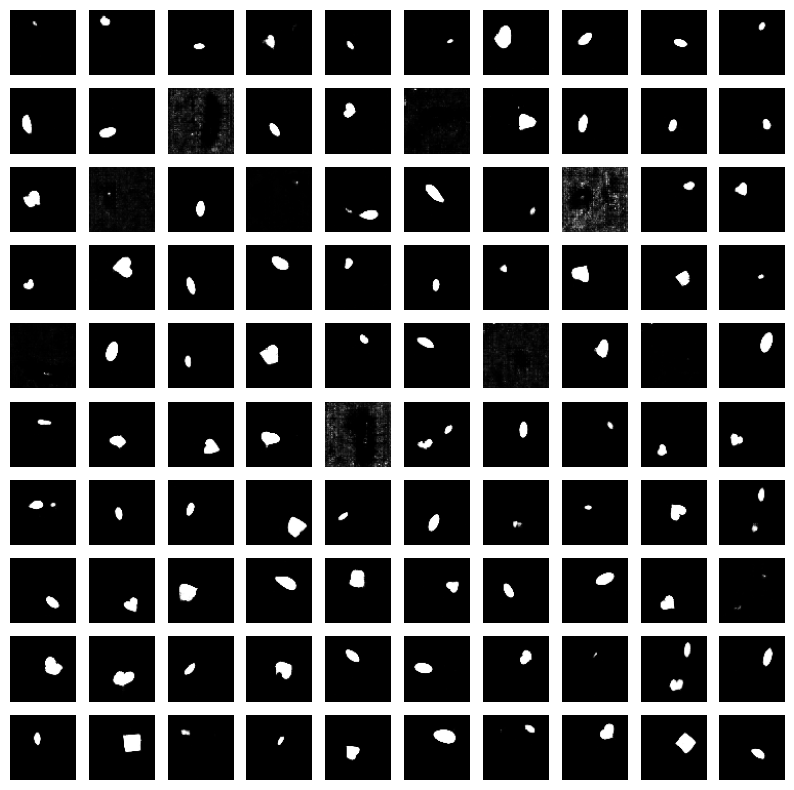

In [18]:
samples = model.sample(100)

# Plot 100 random samples of the generated images in a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].detach().cpu().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


## Calculate FID

In [19]:
fid = FrechetInceptionDistance(reset_real_features=False, normalize=True)
fid = fid.to("cuda")

In [20]:
expand_channels = lambda x: torch.cat([x,x,x], dim=1) 

In [21]:
reconstructions = []
for batch in track(dm.val_dataloader(), total=len(dm.val_dataloader()), description=f"Generating reconstructions for {model_checkpoint}"):
    x, _ = batch
    x = x.to(model.device)
    reconstructions = model(x)[0].detach()
    fid.update(expand_channels(x), real=True)
    fid.update(expand_channels(reconstructions), real=False)

FID = fid.compute()
print(f"FID: {FID}")

Output()

FID: 34.28084945678711
